# Radical Pilot Tutorial

Utilize the example below to familiarize yourself with Radical-Pilot.

* Adapt settings and username 
* Modify the example to print out the hostname of the machine that runs the Pilot


**Please make sure that you always close the session before terminating the notebook using `session.close()`**

## 1 Radical Pilot Setup

Documentation: http://radicalpilot.readthedocs.org/en/latest/machconf.html#preconfigured-resources

First, we will import the necessary dependencies and define some helper functions.

In [29]:
%matplotlib inline
import os, sys
import commands
import radical.pilot as rp
import random
import pandas as pd
import ast
import seaborn as sns

def print_details(detail_object):
    if type(detail_object)==str:
        detail_object = ast.literal_eval(detail_object)
    for i in detail_object:
        detail_object[i]=str(detail_object[i])
    return pd.DataFrame(detail_object.values(), 
             index=detail_object.keys(), 
             columns=["Value"])

os.environ["RADICAL_PILOT_VERBOSE"]="ERROR"
os.environ["RADICAL_PILOT_DBURL"]="mongodb://mongo.radical-cybertools.org:24242/sc15-test000"

!/opt/anaconda/bin/radicalpilot-version

0.37.11.2


## 2. Local Pilot Example

This example shows how to execute a task using a Pilot-Job running on the local machine. In this case, the Pilot-Job is started using **ssh** on the edge node machine of the Hadoop cluster (which runs Jupyterhub - the iPython notebook server).

### 2.1 Create a new Session and Pilot-Manager. 

In [30]:
session = rp.Session()
pmgr = rp.PilotManager(session=session)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_ROUND_ROBIN)
print "Session id: %s Pilot Manager: %s" % (session.uid, str(pmgr.as_dict()))

Session id: rp.session.ip-10-144-47-195.radical.016753.0007 Pilot Manager: {'uid': 'pmgr.0002'}


In [31]:
print_details(umgr.as_dict())

,Value
uid,umgr.0002
scheduler,RoundRobinScheduler
scheduler_details,NO SCHEDULER DETAILS (Not Implemented)


### 2.2 Submit Pilot and add to Unit Manager

In [32]:
pdesc = rp.ComputePilotDescription()
pdesc.resource = "local.localhost_anaconda"  # NOTE: This is a "label", not a hostname
pdesc.runtime  = 10 # minutes
pdesc.cores    = 2
pdesc.cleanup  = False
pilot = pmgr.submit_pilots(pdesc)
umgr.add_pilots(pilot)

In [33]:
print_details(pilot.as_dict())

,Value
uid,pilot.0002
stdout,None
start_time,None
resource_detail,"{'cores_per_node': None, 'nodes': None}"
submission_time,1447543372.63
logfile,None
resource,local.localhost_anaconda
log,[]
sandbox,file://localhost/home/radical/radical.pilot.sa...
state,PendingLaunch


### 2.3 Submit Compute Units

Create a description of the compute unit, which specifies the details on the executed task.

In [34]:
cudesc = rp.ComputeUnitDescription()
cudesc.environment = {'CU_NO': 1}
cudesc.executable  = "/bin/echo"
cudesc.arguments   = ['I am CU number $CU_NO']
cudesc.cores       = 1
print_details(cudesc.as_dict())

,Value
kernel,None
executable,/bin/echo
name,None
restartable,False
output_staging,None
stdout,None
pre_exec,None
mpi,False
environment,{'CU_NO': 1}
cleanup,False


Submit the previously created ComputeUnit descriptions to the PilotManager. This will trigger the selected scheduler to start assigning ComputeUnits to the ComputePilots.

In [35]:
print "Submit Compute Units to Unit Manager ..."
cu_set = umgr.submit_units([cudesc])
print "Waiting for CUs to complete ..."
umgr.wait_units()
print "All CUs completed successfully!"
cu_results = cu_set[0]
details=cu_results.as_dict()

Submit Compute Units to Unit Manager ...
Waiting for CUs to complete ...
All CUs completed successfully!


In [36]:
print_details(details)

,Value
log,[<radical.pilot.logentry.Logentry object at 0x...
state,Done
working_directory,file://localhost/home/radical/radical.pilot.sa...
uid,unit.000022
submission_time,1447543374.61
execution_details,"{u'control': u'umgr', u'stdout': u'I am CU num..."
stop_time,None
start_time,None
exit_code,0
name,None


In [37]:
print_details(details["execution_details"])

,Value
control,umgr
stdout,I am CU number 1\n
callbackhistory,"[{u'timestamp': 1447543374.916241, u'state': u..."
Agent_Output_Directives,[]
Agent_Output_Status,None
Agent_Input_Status,None
exec_locs,None
FTW_Input_Directives,[]
log,"[{u'timestamp': 1447543374.62919, u'message': ..."
exit_code,0


Process Output of CU

In [38]:
print cu_results.stdout.strip()

I am CU number 1


### 2.4 Exercise

Write a Compute Unit that prints out the hostname of the machine!

### 2.5 Performance Analysis

In [12]:
def get_runtime(compute_unit):
    details=compute_unit.as_dict()
    execution_details=details['execution_details']
    state_details=execution_details["statehistory"]
    results = {}
    for i in state_details:
        results[i["state"]]=i["timestamp"]
    start = results["Scheduling"]
    end = results["Done"]
    runtime = end-start
    return runtime

In [13]:
import random
cudesc_list = []
for i in range(20):
    cudesc = rp.ComputeUnitDescription()
    cudesc.executable  = "/bin/sleep"
    cudesc.environment = {'CU_NO': i}
    cudesc.arguments   = ['%d'%(random.randrange(10))]
    cudesc.cores       = 1
    cudesc_list.append(cudesc)

In [14]:
cu_set = umgr.submit_units(cudesc_list)

In [15]:
states = umgr.wait_units()

In [16]:
runtimes=[]
for compute_unit in cu_set:
    str(compute_unit)
    runtimes.append(get_runtime(compute_unit))

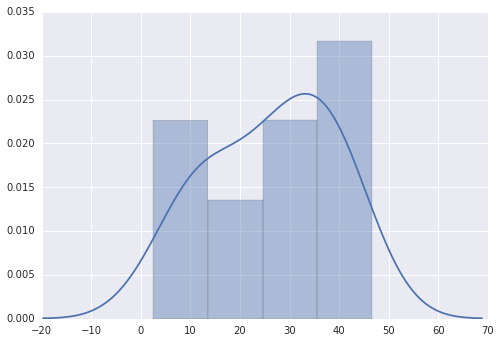

In [17]:
sns.distplot(runtimes)

### 2.6 Close and Delete Session 

In [18]:
session.close()
del session

## 3. YARN Pilot Example

### 3.1 Create a new Session and Pilot-Manager. 

Set the user_id to the account you are using

In [19]:
import getpass
yarn_session = rp.Session()
c = rp.Context('ssh')
c.user_id = getpass.getuser()
yarn_session.add_context(c)
pmgr = rp.PilotManager(session=yarn_session)
umgr = rp.UnitManager(session=yarn_session,
                      scheduler=rp.SCHED_ROUND_ROBIN)
print "Session id: %s Pilot Manager: %s" % (yarn_session.uid, str(pmgr.as_dict()))

Session id: rp.session.ip-10-144-47-195.radical.016753.0002 Pilot Manager: {'uid': 'pmgr.0001'}


### 3.2 Submit Pilot and add to Unit Manager

In [20]:
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "yarn.aws-vm"  # NOTE: This is a "label", not a hostname
pdesc.runtime  = 30 # minutes
pdesc.cores    = 1
pdesc.cleanup  = False
# submit the pilot.
print "Submitting Compute Pilot to Pilot Manager ..."
pilot = pmgr.submit_pilots(pdesc)
umgr.add_pilots(pilot)

Submitting Compute Pilot to Pilot Manager ...


In [21]:
print_details(pilot.as_dict())

,Value
uid,pilot.0001
stdout,None
start_time,None
resource_detail,"{'cores_per_node': None, 'nodes': None}"
submission_time,1447529585.36
logfile,None
resource,yarn.aws-vm
log,[]
sandbox,sftp://sc15-aws.radical-cybertools.org/home/ra...
state,Launching


### 3.3 Submit Compute Units

Create a description of the compute unit, which specifies the details on the executed task.

In [22]:
cudesc = rp.ComputeUnitDescription()
cudesc.environment = {'CU_NO': "1"}
cudesc.executable  = "/bin/echo"
cudesc.arguments   = ['I am CU number $CU_NO']
cudesc.cores       = 1
print_details(cudesc.as_dict())

,Value
kernel,None
executable,/bin/echo
name,None
restartable,False
output_staging,None
stdout,None
pre_exec,None
mpi,False
environment,{'CU_NO': '1'}
cleanup,False


Submit the previously created ComputeUnit descriptions to the PilotManager. This will trigger the selected scheduler to start assigning ComputeUnits to the ComputePilots.

In [23]:
print "Submit Compute Units to Unit Manager ..."
cu_set = umgr.submit_units([cudesc])
print "Waiting for CUs to complete ..."
umgr.wait_units()
print "All CUs completed successfully!"
cu_results = cu_set[0]
details=cu_results.as_dict()

Submit Compute Units to Unit Manager ...
Waiting for CUs to complete ...
All CUs completed successfully!


In [24]:
print_details(details)

,Value
log,[<radical.pilot.logentry.Logentry object at 0x...
state,Done
working_directory,sftp://sc15-aws.radical-cybertools.org/home/ra...
uid,unit.000021
submission_time,1447529585.52
execution_details,"{u'control': u'umgr', u'stdout': u'[... CONTEN..."
stop_time,None
start_time,None
exit_code,0
name,None


In [25]:
print_details(details["execution_details"])

,Value
control,umgr
stdout,[... CONTENT SHORTENED ...]\n ProtobufRpcEngin...
callbackhistory,"[{u'timestamp': 1447529586.379671, u'state': u..."
Agent_Output_Directives,[]
Agent_Output_Status,None
Agent_Input_Status,None
exec_locs,None
FTW_Input_Directives,[]
log,"[{u'timestamp': 1447529585.533021, u'message':..."
exit_code,0


In [26]:
print cu_results.stdout.strip()

[... CONTENT SHORTENED ...]
 ProtobufRpcEngine:250 - Call: getApplicationReport took 1ms
2015-11-14 19:33:37 DEBUG Client:1032 - IPC Client (950834139) connection to /10.63.179.69:8050 from radical sending #541
2015-11-14 19:33:37 DEBUG Client:1089 - IPC Client (950834139) connection to /10.63.179.69:8050 from radical got value #541
2015-11-14 19:33:37 DEBUG ProtobufRpcEngine:250 - Call: getApplicationReport took 2ms
2015-11-14 19:33:37 DEBUG Client:1032 - IPC Client (950834139) connection to /10.63.179.69:8050 from radical sending #542
2015-11-14 19:33:37 DEBUG Client:1089 - IPC Client (950834139) connection to /10.63.179.69:8050 from radical got value #542
2015-11-14 19:33:37 DEBUG ProtobufRpcEngine:250 - Call: getApplicationReport took 1ms
2015-11-14 19:33:37 INFO  Client:792 - Application has completed successfully. Breaking monitoring loop
2015-11-14 19:33:37 INFO  Client:240 - Application completed successfully
2015-11-14 19:33:37 DEBUG Client:97 - stopping client from cache: org

## 4. Close and Delete Session

In [27]:
yarn_session.close()
del yarn_session